In [ ]:
# # 05_forecast.ipynb
# **Goal:** Build forecasting baselines and a time-series model to predict next-month sales.
# - Baseline (naive & mean)
# - Linear Regression on time index
# - ARIMA (statsmodels) time-series model
# - Evaluate on holdout (last 3 months)
# - Save predictions, plots, and model artifact


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# statsmodels for ARIMA
from statsmodels.tsa.arima.model import ARIMA

# create folders
os.makedirs("../reports/images", exist_ok=True)
os.makedirs("../models", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

plt.rcParams.update({"figure.figsize": (10,5), "font.size": 11})


In [3]:
clean_path = "../data/processed/Amazon_Sales_Cleaned.csv"
if not os.path.exists(clean_path):
    raise FileNotFoundError("Cleaned dataset not found. Run cleaning notebook first.")

df = pd.read_csv(clean_path, parse_dates=['Date'], low_memory=False)
print("Loaded:", clean_path, "shape:", df.shape)

# Create monthly series (sum)
monthly = df.resample('M', on='Date')['Total_Amount'].sum().reset_index().sort_values('Date')
monthly.columns = ['Date','Total_Amount']
monthly['MonthStart'] = monthly['Date'].dt.to_period('M').dt.to_timestamp()
monthly = monthly.set_index('MonthStart')[['Total_Amount']]
monthly.index.freq = 'MS'  # ensures monthly start frequency

print("Monthly periods:", monthly.shape[0])
display(monthly.head())


Loaded: ../data/processed/Amazon_Sales_Cleaned.csv shape: (116269, 30)
Monthly periods: 4


,Total_Amount
MonthStart,
2022-03-01,98261.0
2022-04-01,27581851.0
2022-05-01,25118009.0
2022-06-01,22601750.0


In [4]:
# Use last 3 months as holdout (adjust if series shorter)
h = 3
if monthly.shape[0] <= h + 6:
    print("Warning: short time series; using last 1 month as test")
    h = 1

train = monthly.iloc[:-h].copy()
test = monthly.iloc[-h:].copy()

print("Train periods:", train.shape[0], "Test periods:", test.shape[0])
display(train.tail())
display(test)


Train periods: 3 Test periods: 1


,Total_Amount
MonthStart,
2022-03-01,98261.0
2022-04-01,27581851.0
2022-05-01,25118009.0


,Total_Amount
MonthStart,
2022-06-01,22601750.0


In [5]:
def rmse(true, pred):
    return sqrt(mean_squared_error(true, pred))

def mape(true, pred):
    true, pred = np.array(true), np.array(pred)
    return np.mean(np.abs((true - pred) / (true + 1e-9))) * 100

def eval_and_print(name, true, pred):
    print(f"--- {name} ---")
    print("RMSE: ", round(rmse(true, pred),2))
    print("MAE:  ", round(mean_absolute_error(true, pred),2))
    print("MAPE: ", round(mape(true, pred),2), "%")
    print()


--- Naive Forecast ---
RMSE:  2516259.0
MAE:   2516259.0
MAPE:  11.13 %



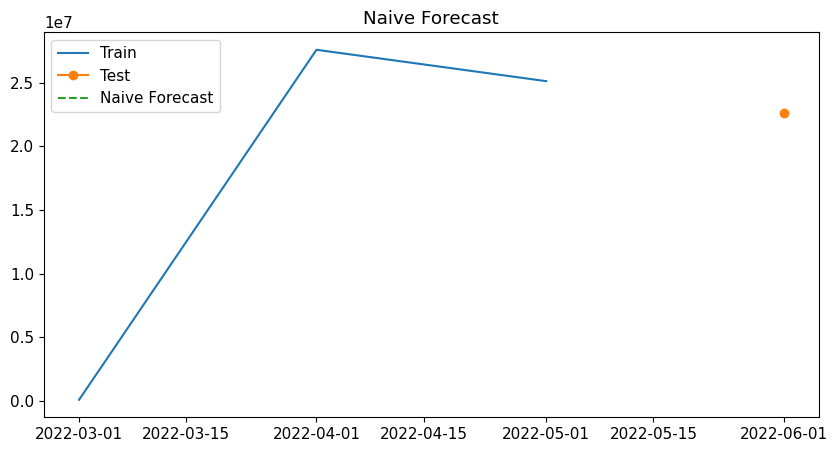

In [6]:
# Naive forecast: use last train value for all horizon
last_val = train['Total_Amount'].iloc[-1]
naive_forecast = pd.Series([last_val]*len(test), index=test.index)

eval_and_print("Naive Forecast", test['Total_Amount'], naive_forecast)

# Plot
plt.plot(train.index, train['Total_Amount'], label='Train')
plt.plot(test.index, test['Total_Amount'], label='Test', marker='o')
plt.plot(naive_forecast.index, naive_forecast.values, label='Naive Forecast', linestyle='--')
plt.title("Naive Forecast")
plt.legend()
plt.savefig("../reports/images/forecast_naive.png", dpi=150)
plt.show()


--- Linear Regression (time index) ---
RMSE:  20017371.67
MAE:   20017371.67
MAPE:  88.57 %



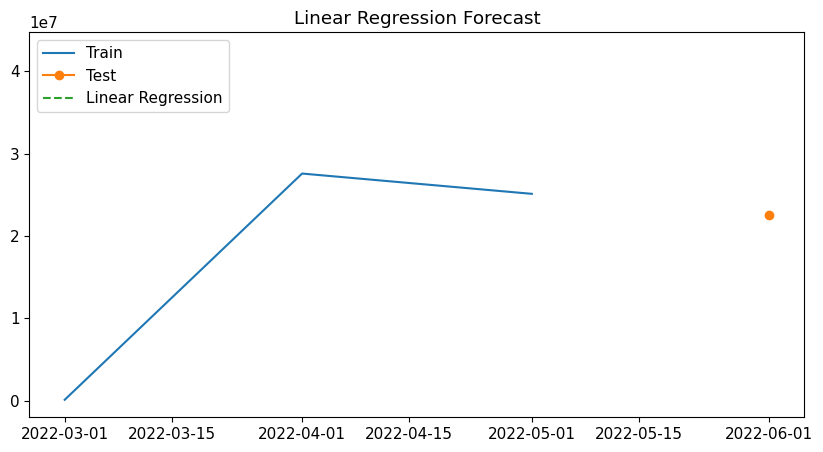

Saved linear regression model to ../models/linear_time_model.pkl


In [7]:
# Prepare time index features
train_lr = train.reset_index().reset_index()  # adds 'index' 0..n
train_lr.rename(columns={'index':'t'}, inplace=True)
train_lr['t'] = np.arange(len(train_lr))

test_lr = test.reset_index().reset_index()
test_lr.rename(columns={'index':'t'}, inplace=True)
test_lr['t'] = np.arange(len(train_lr), len(train_lr) + len(test_lr))

# Fit linear regression
lr = LinearRegression()
lr.fit(train_lr[['t']], train_lr['Total_Amount'])
pred_lr = lr.predict(test_lr[['t']])
pred_lr_series = pd.Series(pred_lr, index=test.index)

eval_and_print("Linear Regression (time index)", test['Total_Amount'], pred_lr_series)

plt.plot(train.index, train['Total_Amount'], label='Train')
plt.plot(test.index, test['Total_Amount'], label='Test', marker='o')
plt.plot(pred_lr_series.index, pred_lr_series.values, label='Linear Regression', linestyle='--')
plt.title("Linear Regression Forecast")
plt.legend()
plt.savefig("../reports/images/forecast_lr.png", dpi=150)
plt.show()

# Save linear model
with open("../models/linear_time_model.pkl", "wb") as f:
    pickle.dump(lr, f)
print("Saved linear regression model to ../models/linear_time_model.pkl")


In [8]:
# Simple ARIMA fit on train
# We'll try a few (p,d,q) candidates and pick lowest AIC (small grid)
candidates = [(1,1,1), (1,0,1), (2,1,1), (0,1,1), (1,1,0)]
best_aic = np.inf
best_order = None
best_model = None

for order in candidates:
    try:
        model = ARIMA(train['Total_Amount'], order=order)
        res = model.fit()
        print(f"Order {order} AIC: {res.aic:.2f}")
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = order
            best_model = res
    except Exception as e:
        print("Order", order, "failed:", e)

print("Best ARIMA order:", best_order, "AIC:", best_aic)


Order (1, 1, 1) AIC: 79.59
Order (1, 0, 1) AIC: 113.66
Order (2, 1, 1) AIC: 79.57
Order (0, 1, 1) AIC: 78.01
Order (1, 1, 0) AIC: 77.13
Best ARIMA order: (1, 1, 0) AIC: 77.13399581098534


--- ARIMA(1, 1, 0) ---
RMSE:  2728311.45
MAE:   2728311.45
MAPE:  12.07 %



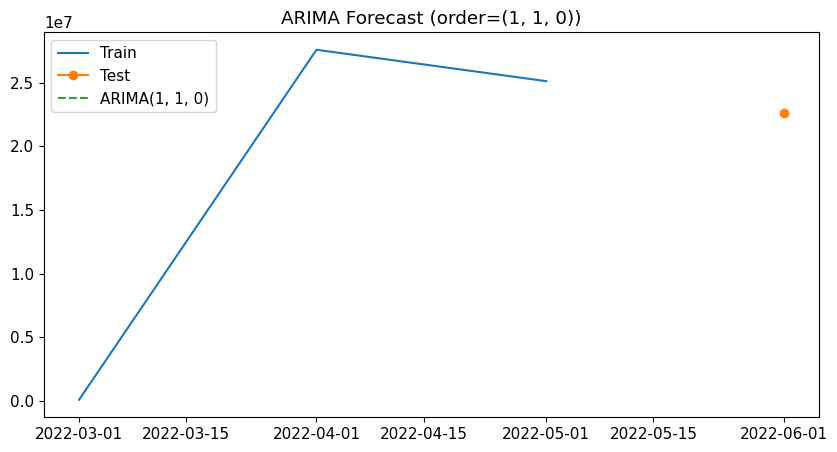

Saved ARIMA model to ../models/arima_model.pkl


In [9]:
# Forecast h steps
if best_model is None:
    raise RuntimeError("ARIMA model failed to fit. Consider adjusting orders or using simple model.")

arima_forecast = best_model.forecast(steps=len(test))
arima_series = pd.Series(arima_forecast, index=test.index)

eval_and_print(f"ARIMA{best_order}", test['Total_Amount'], arima_series)

# Plot
plt.plot(train.index, train['Total_Amount'], label='Train')
plt.plot(test.index, test['Total_Amount'], label='Test', marker='o')
plt.plot(arima_series.index, arima_series.values, label=f'ARIMA{best_order}', linestyle='--')
plt.title(f"ARIMA Forecast (order={best_order})")
plt.legend()
plt.savefig("../reports/images/forecast_arima.png", dpi=150)
plt.show()

# Save ARIMA model
best_model.save("../models/arima_model.pkl")
print("Saved ARIMA model to ../models/arima_model.pkl")


In [10]:
# Combine forecasts into a DataFrame for comparison
results_df = pd.DataFrame({
    'actual': test['Total_Amount'],
    'naive': naive_forecast,
    'linear': pred_lr_series,
    f'arima_{best_order}': arima_series
})
display(results_df)

# Evaluate all
for col in results_df.columns:
    if col != 'actual':
        eval_and_print(col, results_df['actual'], results_df[col])

# Save forecasts and evaluation
results_df.to_csv("../data/processed/forecast_comparison.csv", index=True)
print("Saved forecast comparison to ../data/processed/forecast_comparison.csv")


,actual,naive,linear,"arima_(1, 1, 0)"
MonthStart,,,,
2022-06-01,22601750.0,25118009.0,4.261912e+07,2.533006e+07


--- naive ---
RMSE:  2516259.0
MAE:   2516259.0
MAPE:  11.13 %

--- linear ---
RMSE:  20017371.67
MAE:   20017371.67
MAPE:  88.57 %

--- arima_(1, 1, 0) ---
RMSE:  2728311.45
MAE:   2728311.45
MAPE:  12.07 %

Saved forecast comparison to ../data/processed/forecast_comparison.csv


Final forecast for next period(s):


2022-07-01    2.279610e+07
Freq: MS, dtype: float64

Saved final forecast to ../data/processed/final_forecast_next_months.csv


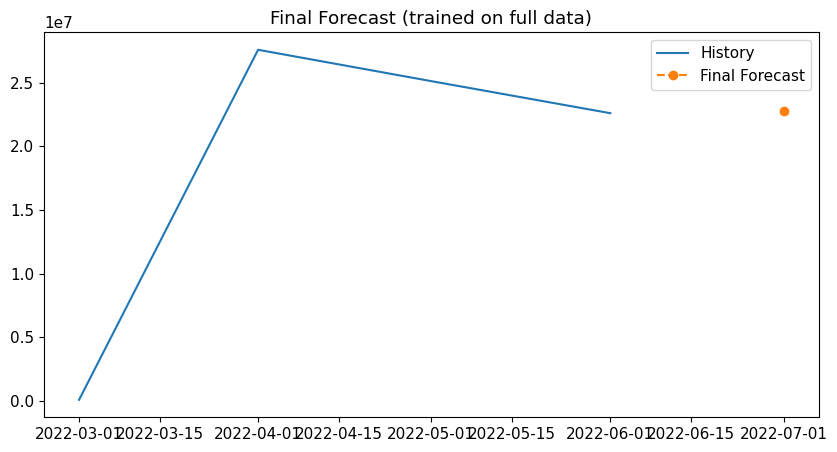

Saved final ARIMA model to ../models/arima_final_full.pkl


In [11]:
# Retrain ARIMA on full series and forecast next 1 month (or choose steps)
full_series = monthly['Total_Amount']
final_order = best_order  # reuse best_order found

model_full = ARIMA(full_series, order=final_order).fit()
steps = 1  # forecast next 1 month, increase if needed e.g., 3
final_forecast = model_full.forecast(steps=steps)

# Create index for future months
last_month = monthly.index[-1]
future_idx = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=steps, freq='MS')
final_forecast_series = pd.Series(final_forecast, index=future_idx)

print("Final forecast for next period(s):")
display(final_forecast_series)

# Save final forecast
final_forecast_series.to_csv("../data/processed/final_forecast_next_months.csv")
print("Saved final forecast to ../data/processed/final_forecast_next_months.csv")

# Plot
plt.plot(monthly.index, monthly['Total_Amount'], label='History')
plt.plot(final_forecast_series.index, final_forecast_series.values, label='Final Forecast', marker='o', linestyle='--')
plt.title("Final Forecast (trained on full data)")
plt.legend()
plt.savefig("../reports/images/final_forecast.png", dpi=150)
plt.show()

# Save full ARIMA retrained model
model_full.save("../models/arima_final_full.pkl")
print("Saved final ARIMA model to ../models/arima_final_full.pkl")


In [12]:
# ## Forecast Notes (to paste in report)
# - Baselines: naive and linear regression (time index) provide simple benchmarks.
# - ARIMA was selected by searching candidate orders and selecting the model with lowest AIC.
# - Evaluation metrics reported: RMSE, MAE, MAPE on holdout period (last 3 months).
# - Final forecast retrains the chosen ARIMA on full data and predicts the next month.
# - Limitations: no exogenous regressors (promotions, price, advertising). Improving accuracy requires richer features (holidays, promotions, external seasonality).
